<a href="https://colab.research.google.com/github/algoritmosdenegociacion/modulo4/blob/main/M4_L2_Modelos_de_ML_para_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos de Negociación basados en Machine Learning - Módulo 4
- Sergio Andrés Cabrales, Ph.D., Universidad de los Andes 
- Juan Pablo Cortés, T.A., Universidad de los Andes

https://github.com/algoritmosdenegociacion/

## 1. Carga de librerías, funciones y APIs necesarias.


#### 1.1. Instalan las librerías que no incluye Google Colab

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=7a1aef2a1ae127fa9db37b87d84984ca1581f1cc89d61259afd8dad6af449f18
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=69f6433a0815b201e12243d574485414f73f16db5c4951ddbc25c226a82385c1
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


#### 1.2. Se cargan las librerías necesarias

In [ ]:
# Funciones numéricas adicionales
import numpy as np

# Lectura de datos y manejo de Data-sets
import pandas as pd

# Datos
import yfinance as yfin

# Gráficos 
import matplotlib.pyplot as plt

# Análisis Técnico
import ta

# Funciones 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Medidas de desempeño
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve

# Support Vector Machine (SVM) / Support Vector Classification (SVC)
from sklearn.svm import SVC

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Redes Neuronales / Multi-layer Perceptron (MLP) 
from sklearn.neural_network import MLPClassifier

## 2. Obtención de datos históricos


https://finance.yahoo.com/

In [ ]:
# Descargamos datos de 1 años de la acción de Tesla
df = yfin.download('BTC-USD',start='2016-01-01', end='2021-01-01')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600
...,...,...,...,...,...,...
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,27084.808594,49056742893
2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,27362.437500,45265946774
2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125,28840.953125,51287442704


## 3. Análisis Técnico 

In [ ]:
# Incluir todo el anáñisis técnico a la base de datos

# Medias móviles exponenciales
df['EMA_5'] = ta.trend.ema_indicator(close=df["Close"], window=5, fillna=True)/df["Close"]
df['EMA_20'] = ta.trend.ema_indicator(close=df["Close"], window=20, fillna=True)/df["Close"]
df['EMA_50'] = ta.trend.ema_indicator(close=df["Close"], window=50, fillna=True)/df["Close"]
df['EMA_100'] = ta.trend.ema_indicator(close=df["Close"], window=100, fillna=True)/df["Close"]

# Índice de fuerza relativa
df['RSI'] = ta.momentum.rsi(close=df["Close"], fillna=True)

# Rango medio verdadero
df['ATR'] = ta.volatility.average_true_range(high=df["High"], low=df["Low"], close=df["Close"], fillna=True)

# Rango de porcentaje de wiliams
df['WR'] = ta.momentum.williams_r(high=df["High"], low=df["Low"], close=df["Close"], fillna=True)

df

,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_20,EMA_50,EMA_100,RSI,ATR,WR
Date,,,,,,,,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,1.000000,1.000000,1.000000,1.000000,100.000000,0.000000,-21.898866
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,1.001378,1.001870,1.001986,1.002026,0.000000,0.000000,-32.161470
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,1.006239,1.008916,1.009581,1.009814,0.000000,0.000000,-54.029560
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,0.999389,1.001575,1.002307,1.002580,43.782411,0.000000,-27.339657
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,1.001337,1.003798,1.004738,1.005102,37.320691,0.000000,-37.140447
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,27084.808594,49056742893,0.953665,0.847414,0.737634,0.634100,78.691073,1246.831527,-13.074509
2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,27362.437500,45265946774,0.962659,0.854167,0.740732,0.635039,79.349097,1256.587981,-10.304209
2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125,28840.953125,51287442704,0.942206,0.828438,0.714415,0.610355,82.456164,1279.521010,-1.256475


In [ ]:
# Crea el Target (1 si el precio sube el día siguiente, -1 si baja)
cl = np.array(df['Close'])
target = np.where(cl[1:] > cl[:-1], 1, -1)

# Elimina el ultimo día para el que no tenemos info del precio el día siguiente.
df.drop(df.tail(1).index, inplace=True)

# Creamos la columna target
df['Target'] = target

# Elimina los primeros 29 días dónde los indicadores técnicos no tienen suficiente info
df.drop(df.head(29).index, inplace=True)

df

,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_20,EMA_50,EMA_100,RSI,ATR,WR,Target
Date,,,,,,,,,,,,,,
2016-01-30,378.864990,380.916992,376.490997,378.255005,378.255005,30284400,1.014102,1.053229,1.094312,1.117589,39.405583,15.224229,-78.595656,-1
2016-01-31,378.292999,380.346985,367.834991,368.766998,368.766998,37894300,1.026796,1.072678,1.117665,1.143446,36.506644,15.030498,-94.457908,1
2016-02-01,369.350006,378.071991,367.957001,373.056000,373.056000,51656700,1.009994,1.054598,1.100705,1.127720,38.701944,14.679390,-87.287464,1
2016-02-02,372.920013,375.882996,372.920013,374.447998,374.447998,40378700,1.004160,1.045851,1.092825,1.121081,39.433863,13.842504,-84.960291,-1
2016-02-03,374.645996,374.950012,368.045013,369.949005,369.949005,45933400,1.010914,1.052992,1.101953,1.132047,37.860379,13.346968,-92.168902,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,26272.294922,66479895605,0.959275,0.857064,0.749406,0.646090,76.670934,1251.859283,-21.739074,1
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,27084.808594,49056742893,0.953665,0.847414,0.737634,0.634100,78.691073,1246.831527,-13.074509,1
2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,27362.437500,45265946774,0.962659,0.854167,0.740732,0.635039,79.349097,1256.587981,-10.304209,1


## 4. Conjunto de entrenamiento y prueba

In [ ]:
# Divida el conjunto de datos en una característica o un conjunto de datos independiente (X) y un destino o conjunto de datos dependiente (Y)
X = np.array(df.iloc[:, 6:-1])
Y = np.array(df['Target'])

print(X.shape)
print(Y.shape)

(1794, 7)
(1794,)


In [ ]:
# Vuelva a dividir los datos, pero esta vez en 90% de entrenamiento y 10% de prueba.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, shuffle=False)

print(X_train.shape)
print(X_test.shape)

(1614, 7)
(180, 7)


In [ ]:
#Standardization
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## 5. Machine Learning - Support Vector Classifier (SVC)

In [ ]:
# Crear el modelo clasificador de Support Vector Machine.
# Kernel radial
svc = SVC(kernel='rbf')

# Entrenar el modelo de SVM
svc = svc.fit(X_train, Y_train)

In [ ]:
# Compruebe cómo le fue al modelo en el conjunto de datos de prueba
svm_pred = svc.predict(X_test)

print("Accuracy: {:.4f}\n".format( accuracy_score(Y_test, svm_pred) ))

print("Confusion Matrix:")
print( confusion_matrix(Y_test, svm_pred) )

Accuracy: 0.5778

Confusion Matrix:
[[16 54]
 [22 88]]


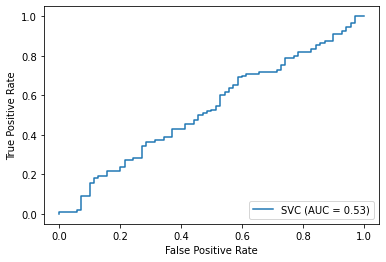

In [ ]:
# Curva ROC y AUC.
plot_roc_curve(svc, X_test, Y_test)

## 6. Machine Learning - Decision Tree Classifer

In [ ]:
# Crear el modelo clasificador de Árbol de Decisión.
dtc = DecisionTreeClassifier()

# Entrenar el Árbol de Decisión
dtc = dtc.fit(X_train, Y_train)

In [ ]:
# Compruebe cómo le fue al modelo en el conjunto de datos de prueba
dtc_pred = dtc.predict(X_test)

print("Accuracy: {:.4f}\n".format( accuracy_score(Y_test, dtc_pred) ))

print("Confusion Matrix:")
print( confusion_matrix(Y_test, dtc_pred) )

Accuracy: 0.5167

Confusion Matrix:
[[35 35]
 [52 58]]


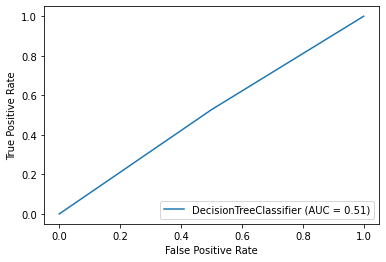

In [ ]:
# Curva ROC y AUC.
plot_roc_curve(dtc, X_test, Y_test)
plt.show()

## 7. Machine Learning - Random Forest Classifier

In [ ]:
# Crear el modelo clasificador de Random Forest.
rfc = RandomForestClassifier()

# Entrenar el modelo de Random Forest
rfc = rfc.fit(X_train, Y_train)

In [ ]:
# Compruebe cómo le fue al modelo en el conjunto de datos de prueba
rfc_pred = rfc.predict(X_test)

print("Accuracy: {:.4f}\n".format( accuracy_score(Y_test, rfc_pred) ))

print("Confusion Matrix:")
print( confusion_matrix(Y_test, rfc_pred) )

Accuracy: 0.6500

Confusion Matrix:
[[46 24]
 [39 71]]


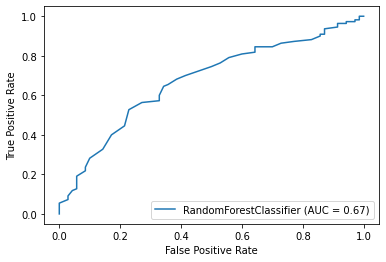

In [ ]:
# Curva ROC y AUC.
plot_roc_curve(rfc, X_test, Y_test)
plt.show()

## 8. Machine Learning - Redes neuronales / Multilayer Perceptron (MLP)

In [ ]:
# Redes Neuronales / Multi-layer Perceptron (MLP) 
from sklearn.neural_network import MLPClassifier

In [ ]:
# Crear el modelo clasificador de Redes Neuronales.
mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000)

# Entrenar el modelo de Redes Neuronales
mlp = mlp.fit(X_train, Y_train)

In [ ]:
# Compruebe cómo le fue al modelo en el conjunto de datos de prueba
mlp_pred = mlp.predict(X_test)

print("Accuracy: {:.4f}\n".format( accuracy_score(Y_test, mlp_pred) ))

print("Confusion Matrix:")
print( confusion_matrix(Y_test, mlp_pred) )

Accuracy: 0.5722

Confusion Matrix:
[[32 38]
 [39 71]]


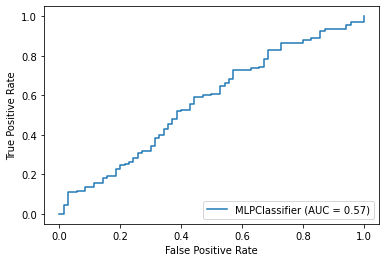

In [ ]:
# Get the model metrics
plot_roc_curve(mlp, X_test, Y_test)
plt.show()

## 9. Backtesting - Random Forest

#### 9.1. Cálculo de capital a lo largo de la venta de tiempo

In [ ]:
N = len(rfc_pred)
df_test = df.tail(N)
df_test['Signals'] = rfc_pred
df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_20,EMA_50,EMA_100,RSI,ATR,WR,Target,Signals
Date,,,,,,,,,,,,,,,
2020-07-02,9231.139648,9274.962891,9036.623047,9123.410156,9123.410156,16338916796,1.005101,1.019298,1.009373,0.973117,44.032499,242.027955,-79.018729,-1,1
2020-07-03,9124.842773,9202.344727,9058.794922,9087.303711,9087.303711,13078970999,1.006063,1.021124,1.012859,0.977439,43.071245,234.993801,-84.141360,1,1
2020-07-04,9084.233398,9183.295898,9053.629883,9132.488281,9132.488281,12290528515,1.000724,1.014541,1.007540,0.973146,44.698268,227.470388,-77.730763,-1,1
2020-07-05,9126.090820,9162.183594,8977.015625,9073.942383,9073.942383,12903406143,1.004787,1.019079,1.013490,0.979832,42.984072,224.448787,-86.037010,1,1
2020-07-06,9072.849609,9375.474609,9058.664062,9375.474609,9375.474609,17889263252,0.981647,0.987608,0.981643,0.949342,52.984773,231.046055,-43.256881,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,26272.294922,66479895605,0.959275,0.857064,0.749406,0.646090,76.670934,1251.859283,-21.739074,1,1
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,27084.808594,49056742893,0.953665,0.847414,0.737634,0.634100,78.691073,1246.831527,-13.074509,1,1
2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,27362.437500,45265946774,0.962659,0.854167,0.740732,0.635039,79.349097,1256.587981,-10.304209,1,1


In [ ]:
# Crea una lista para almacenar el capital
# Emezamos con 100 USD
equity = [100]

# Take Profit al 3% y Stop Loss al 1%
TP = 0.03
SL = 0.01

pos = 0
price = -1

# Recorre la ventana de tiempo a partir del día 1
for i in range(1, N):
  
  equity.append( equity[i-1] )

  if pos == 1:
    
    if df_test['Close'][i] >= price*(1 + TP):
      equity[i] *= 1 + TP
      pos = 0
    
    elif df_test['Close'][i] <= price*(1 - SL):
      equity[i] *= 1 - SL
      pos = 0

  elif pos == -1:

    if df_test['Close'][i] <= price*(1 - TP):
      equity[i] *= 1 + TP
      pos = 0
    
    elif df_test['Close'][i] >= price*(1 + SL):
      equity[i] *= 1 - SL
      pos = 0

  else:

    if df_test['Signals'][i] != 0:
      pos = df_test['Signals'][i]
      price = df_test['Close'][i]

df_test['Equity'] = equity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### 9.2. Gráfico del capital

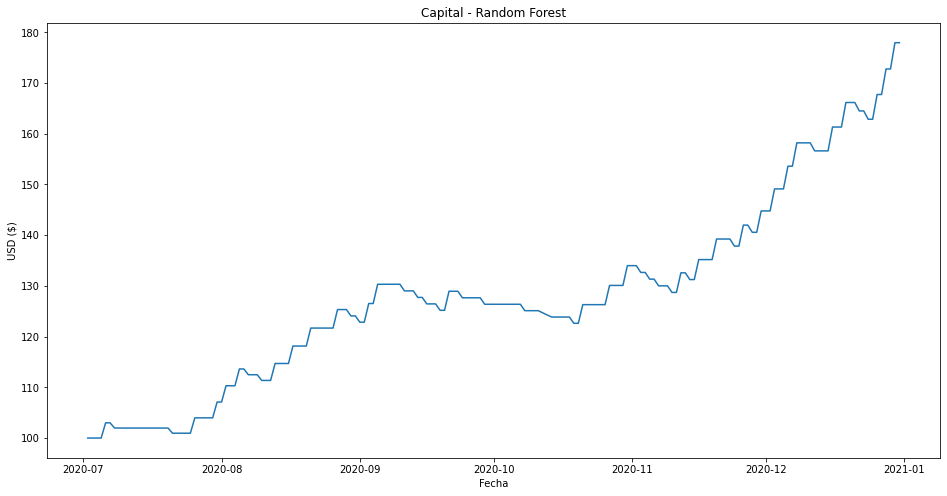

In [ ]:
# Mostrar visualmente el equity a lo largo de la ventana de tiempo
plt.figure(figsize=(16,8))
plt.plot(df_test['Equity'])

plt.title('Capital - Random Forest')
plt.xlabel('Fecha')
plt.ylabel('USD ($)')
plt.show()

#### 9.3. Comparación con un portafolio de mercado

In [ ]:
mkt = yfin.download('^GSPC', start='2020-07-02', end='2020-12-31')
mkt

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-02,3143.639893,3165.810059,3124.520020,3130.010010,3130.010010,4190830000
2020-07-06,3155.290039,3182.590088,3155.290039,3179.719971,3179.719971,4736450000
2020-07-07,3166.439941,3184.149902,3142.929932,3145.320068,3145.320068,4563700000
2020-07-08,3153.070068,3171.800049,3136.530029,3169.939941,3169.939941,4927700000
2020-07-09,3176.169922,3179.780029,3115.699951,3152.050049,3152.050049,4829020000
...,...,...,...,...,...,...
2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3690.010010,3772630000
2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1885090000
2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3527460000


In [ ]:
mkt['Equity'] = (100/mkt['Close'][0])*mkt['Close']
mkt

,Open,High,Low,Close,Adj Close,Volume,Equity
Date,,,,,,,
2020-07-02,3143.639893,3165.810059,3124.520020,3130.010010,3130.010010,4190830000,100.000000
2020-07-06,3155.290039,3182.590088,3155.290039,3179.719971,3179.719971,4736450000,101.588173
2020-07-07,3166.439941,3184.149902,3142.929932,3145.320068,3145.320068,4563700000,100.489138
2020-07-08,3153.070068,3171.800049,3136.530029,3169.939941,3169.939941,4927700000,101.275713
2020-07-09,3176.169922,3179.780029,3115.699951,3152.050049,3152.050049,4829020000,100.704152
...,...,...,...,...,...,...,...
2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3690.010010,3772630000,117.891317
2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1885090000,118.308250
2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3527460000,119.340197


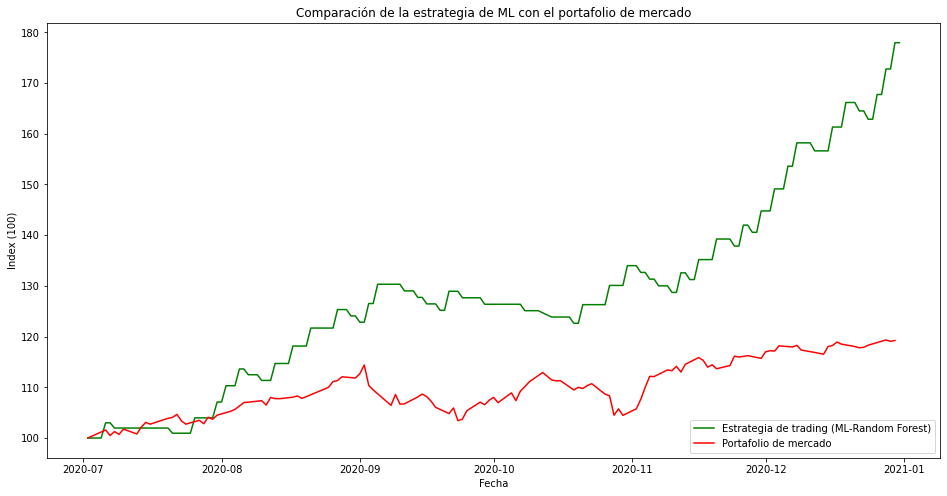

In [ ]:
# Comparación de la estrategia con el portafolio de mercado
plt.figure(figsize=(16,8))
plt.plot(df_test['Equity'], color = 'green', label = 'Estrategia de trading (ML-Random Forest)')
plt.plot(mkt['Equity'], color = 'red', label = 'Portafolio de mercado')

plt.title('Comparación de la estrategia de ML con el portafolio de mercado')
plt.xlabel('Fecha')
plt.ylabel('Index (100)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Desempeño de la estrategia planteada
ret = 252*np.log(df_test['Equity']).diff().mean()
print('Retorno esperado anulizado: {:.4f}'.format(ret))

vol = np.sqrt(252)*np.log(df_test['Equity']).diff().std()
print('Volatilidad anulizada: {:.4f}'.format(vol))

sharpe_ratio = (ret - 0.01)/vol
print('Sharpe Ratio: {:.4f}'.format(sharpe_ratio))

Retorno esperado anulizado: 0.8115
Volatilidad anulizada: 0.1886
Sharpe Ratio: 4.2487


In [ ]:
# Desempeño del portafolio de mercado
ret = 252*np.log(mkt['Equity']).diff().mean()
print('Retorno esperado anulizado: {:.4f}'.format(ret))

vol = np.sqrt(252)*np.log(mkt['Equity']).diff().std()
print('Volatilidad anulizada: {:.4f}'.format(vol))

sharpe_ratio = (ret - 0.01)/vol
print('Sharpe Ratio: {:.4f}'.format(sharpe_ratio))

Retorno esperado anulizado: 0.3547
Volatilidad anulizada: 0.1676
Sharpe Ratio: 2.0570
